In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import numpy as np
class SaveModelCallback(tf.keras.callbacks.Callback):
    """
    Save best model if vall loss is smaller, used for Transformers package
  """

    def __init__(self, name):
        super(SaveModelCallback, self).__init__()
        self.name = name


    def on_train_begin(self, logs=None):
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        self.model.save(self.name + " " + str(epoch))

            


In [3]:
def top_k_logits(logits, k):
    if k == 0:
        # no truncation
        return logits

    def _top_k():
        values, _ = tf.nn.top_k(logits, k=k)
        min_values = values[:, -1, tf.newaxis]
        return tf.compat.v1.where(
            logits < min_values,
            tf.ones_like(logits, dtype=logits.dtype) * -1e10,
            logits,
        )
    return tf.cond(
        pred=tf.equal(k, 0),
        true_fn=lambda: logits,
        false_fn=lambda: _top_k(),
    )


def top_p_logits(logits, p):
    with tf.compat.v1.variable_scope('top_p_logits'):
        logits_sort = tf.sort(logits, direction='DESCENDING')
        probs_sort = tf.nn.softmax(logits_sort)
        probs_sums = tf.cumsum(probs_sort, axis=1, exclusive=True)
        logits_masked = tf.compat.v1.where(probs_sums < p, logits_sort, tf.ones_like(
            logits_sort)*1000)  # [batchsize, vocab]
        min_logits = tf.reduce_min(input_tensor=logits_masked, axis=1, keepdims=True)  # [batchsize, 1]
        return tf.compat.v1.where(
            logits < min_logits,
            tf.ones_like(logits, dtype=logits.dtype) * -1e10,
            logits,
        )
    

def sample(logits, temperature, top_p, top_k):
    logits = logits / tf.cast(temperature, tf.float32)
    if top_p > 0.0:
        logits = top_p_logits(logits, p=top_p)
    else:
        logits = top_k_logits(logits, k=top_k)
    samples = tf.random.categorical(
        logits, num_samples=1, dtype=tf.int32)
    return samples


def generate(model, context, temperature, top_p, top_k, n_words):
    model.reset_states()
    first = model.predict(context)
    prediction = sample(first[:,-1,:], temperature, top_p, top_k)
    context = tf.concat([context, prediction], axis=1)
    for i in range(n_words-1):
        logits = model.predict(context[:,-1:])
        prediction = sample(logits[:,-1,:], temperature, top_p, top_k)
        context = tf.concat([context, prediction], axis=1)
    res = tf.squeeze(context)
    return res.numpy()

In [4]:
with open("data_splits/trumpGeneratorTextTrain.txt", encoding = "utf-8") as f:
    train = f.read()
    
with open("data_splits/trumpGeneratorTextValid.txt", encoding = "utf-8") as f:
    valid = f.read()

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokens = tokenizer(train, add_special_tokens=False, return_tensors="tf")

x_train = tokens["input_ids"][:,:-1]
y_train = tokens["input_ids"][:,1:]
ntrain = x_train.shape[1]

tokens = tokenizer(valid, add_special_tokens=False, return_tensors="tf")

x_valid = tokens["input_ids"][:,:-1]
y_valid = tokens["input_ids"][:,1:]
nvalid = x_valid.shape[1]

Token indices sequence length is longer than the specified maximum sequence length for this model (351805 > 1024). Running this sequence through the model will result in indexing errors


In [6]:
def generator_train_stateful(window_size, model):
    """In addition to the window_size, the generator also takes the model as input so
    that we can reset the RNN states at appropiate intervals."""
    
    # Compute the total number of windows of length window_size that we need to cover all the training data.
    #  Note 1. The length of x_train (and yt_train) is ntrain-1 since we work with 1-step prediction.
    #  Note 2. The final window could be smaller than window_size, if (ntrain-1) is not evenly divisable by the window_size.    
    number_of_windows = int((ntrain)/ window_size)
    
    while True:
        for i in range(number_of_windows):
            # First time index of window (inclusive)
            start_of_window = i*window_size
            
            # Last time index of window (exclusive, i.e. this is the index to the first time step after the window)
            # Note 3. Python allows using end_of_window > ntrain-1, it will simply truncate the indexing at the final element of the array!
            end_of_window = start_of_window + window_size
            
            yield x_train[:,start_of_window:end_of_window], y_train[:,start_of_window:end_of_window]
        model.reset_states()
            
    """NOTE! In addition to replacing the ????? with the correct code, you need to move the line"""
        
    """to the correct place in the function definition above!"""
            

In [7]:
def generator_valid(window_size):    
    while True:
        """The upper value is excluded in randint, so the maximum value that we can get is tt = ntrain-window_size-1.
        Hence, the maximum end point of a window is ntrain-1, in agreement with the fact that the size of input/output is ntrain-1
        when working with one-step-ahead prediction.""" 
        start_of_window = np.random.randint(0, nvalid - window_size)  # First time index of window (inclusive)
        end_of_window = start_of_window + window_size  # Last time index of window (exclusive, i.e. this is really the first index _after_ the window)
        yield x_valid[:,start_of_window:end_of_window], y_valid[:,start_of_window:end_of_window]

In [2]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=50257, output_dim=100, batch_input_shape=(1,None)))
# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(254, return_sequences=True, stateful=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(254 , return_sequences=True, stateful=True))
model.add(layers.Dropout(0.5))
# Add a Dense layer with 10 units.
model.add(layers.Dense(500))
model.add(layers.Dense(50257))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 100)            5025700   
_________________________________________________________________
lstm (LSTM)                  (1, None, 254)            360680    
_________________________________________________________________
dropout (Dropout)            (1, None, 254)            0         
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 254)            517144    
_________________________________________________________________
dropout_1 (Dropout)          (1, None, 254)            0         
_________________________________________________________________
dense (Dense)                (1, None, 500)            127500    
_________________________________________________________________
dense_1 (Dense)              (1, None, 50257)          2

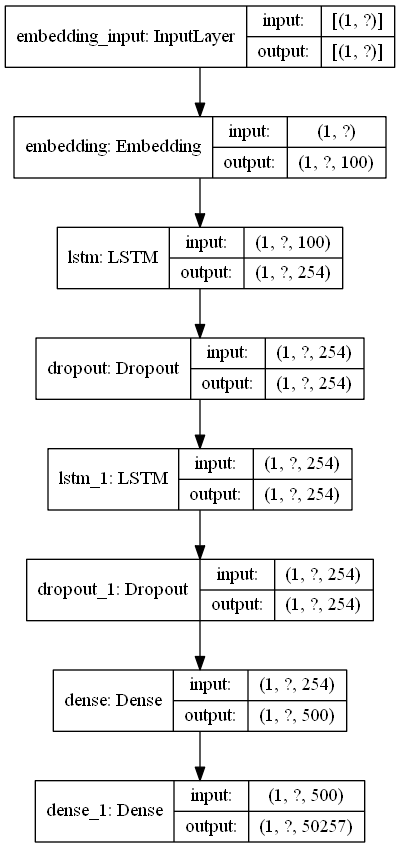

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [19]:
window_size = 1000

In [20]:


model_checkpoint_callback = SaveModelCallback(
    name="generators/LSTM/LSTM_Generator")


model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam"
)

history = model.fit(generator_train_stateful(window_size,model),
           epochs = 100, 
           steps_per_epoch = int((ntrain)/ window_size),
            validation_data = generator_valid(window_size),
            validation_steps = int((nvalid)/ window_size),
           callbacks=[model_checkpoint_callback])



Epoch 1/100
351/351 [==============================] - ETA: 0s - loss: 6.0125WARNING:tensorflow:From C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: generators/LSTM/LSTM_Generator 0\assets
351/351 [==============================] - 102s 290ms/step - loss: 6.0125 - val_loss: 5.2538
Epoch 2/100
351/351 [==============================] - 104s 297ms/step - loss: 5.0715 - val_loss: 4.8354
Epoch 3/100
351/351 [==============================] - 107s 304ms/step - loss: 4.7383 - val_loss: 4.6229
Epoch 4/100
351/351 [==============================] - 

351/351 [==============================] - 106s 301ms/step - loss: 3.0494 - val_loss: 3.9306
Epoch 65/100
351/351 [==============================] - 104s 297ms/step - loss: 3.0380 - val_loss: 4.0004
Epoch 66/100
351/351 [==============================] - 104s 298ms/step - loss: 3.0283 - val_loss: 3.9516
Epoch 67/100
351/351 [==============================] - 104s 296ms/step - loss: 3.0237 - val_loss: 3.9974
Epoch 68/100
351/351 [==============================] - 104s 297ms/step - loss: 3.0171 - val_loss: 3.9702
Epoch 69/100
351/351 [==============================] - 104s 297ms/step - loss: 3.0100 - val_loss: 3.8747
Epoch 70/100
351/351 [==============================] - 104s 297ms/step - loss: 3.0020 - val_loss: 4.0236
Epoch 71/100
351/351 [==============================] - 105s 300ms/step - loss: 2.9954 - val_loss: 4.0105
Epoch 72/100
351/351 [==============================] - 104s 296ms/step - loss: 2.9867 - val_loss: 4.0047
Epoch 73/100
351/351 [==============================] - 104

In [21]:
history.history

{'loss': [6.012487888336182,
  5.071495532989502,
  4.738304615020752,
  4.53843355178833,
  4.392847537994385,
  4.282917499542236,
  4.196750164031982,
  4.120655059814453,
  4.054551124572754,
  3.9963667392730713,
  3.9454245567321777,
  3.900789499282837,
  3.859717845916748,
  3.8233232498168945,
  3.7851572036743164,
  3.753582239151001,
  3.724238872528076,
  3.6950440406799316,
  3.6664083003997803,
  3.6404597759246826,
  3.6118831634521484,
  3.5900206565856934,
  3.565584897994995,
  3.5444843769073486,
  3.5240750312805176,
  3.50545597076416,
  3.486555814743042,
  3.4657647609710693,
  3.44771146774292,
  3.430805206298828,
  3.4154977798461914,
  3.3986082077026367,
  3.3811957836151123,
  3.3674073219299316,
  3.353691577911377,
  3.337703227996826,
  3.3254644870758057,
  3.3120577335357666,
  3.2987732887268066,
  3.2860593795776367,
  3.275585651397705,
  3.258976936340332,
  3.2492401599884033,
  3.2361536026000977,
  3.2245185375213623,
  3.21527361869812,
  3.202

In [22]:
import dill as pickle
pickle._dill._reverse_typemap['ClassType'] = type

objectRep = open("generators/LSTMhistory.obj", "wb")
POSclassiefier = pickle.dump(history.history,objectRep)
objectRep.close()

In [23]:
context = " everything will be great"
tokenized = tokenizer(context)["input_ids"]
tokens_prep = np.array([tokenized])

In [32]:
gen_data = generate(model, tokens_prep, 0.7, 0.9, 100, 130)

In [33]:
len(tokenizer.decode(gen_data).split(" "))

111

# evaluation: 

In [28]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import spacy
import en_core_web_sm
from scipy.stats import ttest_ind
import os
import pandas as pd
from matplotlib import pyplot as plt
import dill as pickle
import tqdm

model is chosen which minimizes validation loss 

In [12]:
import dill as pickle
objectRep = open("generators/LSTMhistory.obj", "rb")
history = pickle.load(objectRep)
objectRep.close()

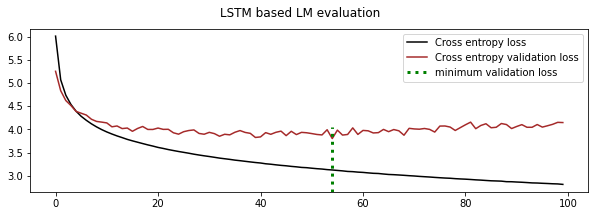

In [22]:
plt.rcParams['figure.figsize'] = [10, 3]
fig, axs = plt.subplots(1, sharex=True)
l = len(history["loss"])
fig.suptitle("LSTM based LM evaluation")
plot_1 = axs.plot(np.arange(l), history["loss"], label = "Cross entropy loss", color = "black")
plot_2 = axs.plot(np.arange(l), history["val_loss"], label = "Cross entropy validation loss", color = "brown")
axs.axvline(x=history["val_loss"].index(min(history["val_loss"])), ymax=0.4, color='g', linestyle=':', linewidth=3, label = "minimum validation loss")
axs.legend()
#labels = [l.get_label() for l in lns]
#plt.legend(lns, labels, loc=0)

plt.show()

In [23]:
history["val_loss"].index(min(history["val_loss"]))

54

In [34]:
min(history["val_loss"])

3.8025641441345215

## Tune sampling parameters

sampling parameters will be tuned to maximise m-bleu4 score

### load scores and methods

In [25]:
import random
import os 
def randcontext(text,lensen):
    gentrainwords = text.split(" ")
    ran = len(gentrainwords)-lensen
    x = random.randint(0,ran)
    text = " ".join(gentrainwords[x:(x+lensen)])
    return text

def generateText(model,tokenizer,context, t = 0.7, p = 0.9, k = 100):
    prompt = context
    inputs = tokenizer(prompt, add_special_tokens=False, return_tensors="tf")["input_ids"]
    gen_data = generate(model, inputs, t, p, k, 130)
    generated = prompt + tokenizer.decode(gen_data)
    return generated

def save_to_file(string, path):
    with open(path, 'w', encoding = "utf-8") as output_file:
        output_file.write(string)
        
def splitTolenWords(text, nwords):
    words = text.split(" ")
    count = int(len(words)/nwords)
    sentences = [" ".join(words[(i*nwords):((i+1)*nwords)]) for i in range(count)]
    return(sentences)

def unnameTextWithM(text):
    nlp = en_core_web_sm.load()
    doc = nlp(text)
    text = text
    for ent in reversed(doc.ents):
        text = text[:ent.start_char] + "<M>" + text[ent.end_char:] 
    return text

def bleu_scores(string, valid_data):
    valid = [i.split(" ") for i in valid_data]
    string = string.split(" ")[:100]
    bleu4 = sentence_bleu(valid, string ,weights = (0.25,0.25,0.25,0.25))
    return (bleu4)

def evaluate(genvalid, genstr):
    strM = unnameTextWithM(genstr)
    b4 = bleu_scores(strM, genvalid)
    return (b4, )

def read_from_file(path):
    with open(path, 'r') as output_file:
        string = output_file.read()
    return string

### load validation data 

In [26]:
with open("data_splits/trumpGeneratorTextValid.txt", encoding = "utf-8") as f:
    genvalid = splitTolenWords(f.read(), 100)

# sampling tunning 

In [29]:
temp = [0.2,0.4,0.6,0.8,1]
k = [5,10,20,50]
p = [0.2,0.6,0.8,1.0]

bar = tqdm.tqdm(total = len(temp) * len(k) * len(p))
path = "generators/LSTM/" + "LSTM_Generator 54"
model = tf.keras.models.load_model(path)
for t in temp:
    for ki in k:
        for pi in p:
            print(t,ki,pi)
            filename = "LSTM " + str((t, ki, pi))
            for i in range(10):
                context = randcontext(train,4)
                string = generateText(model,tokenizer,context, t = t, p = pi, k = ki)
                save_path = "generators/LSTM_texts/sampling_texts/"+ filename + " " +  str(i)+ " " + ".txt"
                save_to_file(string,save_path)
            bar.update(1)

  0%|          | 0/80 [00:00<?, ?it/s]

0.2 5 0.2


  1%|▏         | 1/80 [00:56<1:13:46, 56.03s/it]

0.2 5 0.6


  2%|▎         | 2/80 [01:43<1:06:00, 50.78s/it]

0.2 5 0.8


  4%|▍         | 3/80 [02:30<1:03:07, 49.19s/it]

0.2 5 1.0


  5%|▌         | 4/80 [03:17<1:01:18, 48.39s/it]

0.2 10 0.2


  6%|▋         | 5/80 [04:04<59:49, 47.86s/it]  

0.2 10 0.6


  8%|▊         | 6/80 [04:53<59:26, 48.20s/it]

0.2 10 0.8


  9%|▉         | 7/80 [05:46<1:00:26, 49.68s/it]

0.2 10 1.0


 10%|█         | 8/80 [06:37<1:00:16, 50.23s/it]

0.2 20 0.2


 11%|█▏        | 9/80 [07:32<1:01:10, 51.70s/it]

0.2 20 0.6


 12%|█▎        | 10/80 [08:24<1:00:35, 51.94s/it]

0.2 20 0.8


 14%|█▍        | 11/80 [09:16<59:26, 51.69s/it]  

0.2 20 1.0


 15%|█▌        | 12/80 [10:09<59:02, 52.10s/it]

0.2 50 0.2


 16%|█▋        | 13/80 [11:02<58:39, 52.53s/it]

0.2 50 0.6


 18%|█▊        | 14/80 [11:56<58:08, 52.85s/it]

0.2 50 0.8


 19%|█▉        | 15/80 [12:49<57:25, 53.01s/it]

0.2 50 1.0


 20%|██        | 16/80 [13:39<55:36, 52.14s/it]

0.4 5 0.2


 21%|██▏       | 17/80 [14:29<53:53, 51.32s/it]

0.4 5 0.6


 22%|██▎       | 18/80 [15:18<52:31, 50.84s/it]

0.4 5 0.8


 24%|██▍       | 19/80 [16:10<52:00, 51.16s/it]

0.4 5 1.0


 25%|██▌       | 20/80 [17:03<51:35, 51.59s/it]

0.4 10 0.2


 26%|██▋       | 21/80 [17:55<51:00, 51.87s/it]

0.4 10 0.6


 28%|██▊       | 22/80 [18:47<50:02, 51.76s/it]

0.4 10 0.8


 29%|██▉       | 23/80 [19:37<48:40, 51.24s/it]

0.4 10 1.0


 30%|███       | 24/80 [20:28<47:52, 51.29s/it]

0.4 20 0.2


 31%|███▏      | 25/80 [21:23<47:53, 52.25s/it]

0.4 20 0.6


 32%|███▎      | 26/80 [22:21<48:36, 54.02s/it]

0.4 20 0.8


 34%|███▍      | 27/80 [23:14<47:25, 53.69s/it]

0.4 20 1.0


 35%|███▌      | 28/80 [24:08<46:34, 53.74s/it]

0.4 50 0.2


 36%|███▋      | 29/80 [24:59<45:04, 53.02s/it]

0.4 50 0.6


 38%|███▊      | 30/80 [25:51<43:58, 52.78s/it]

0.4 50 0.8


 39%|███▉      | 31/80 [26:44<43:01, 52.68s/it]

0.4 50 1.0


 40%|████      | 32/80 [27:39<42:46, 53.47s/it]

0.6 5 0.2


 41%|████▏     | 33/80 [28:40<43:41, 55.77s/it]

0.6 5 0.6


 42%|████▎     | 34/80 [29:31<41:41, 54.39s/it]

0.6 5 0.8


 44%|████▍     | 35/80 [30:23<40:08, 53.53s/it]

0.6 5 1.0


 45%|████▌     | 36/80 [31:17<39:19, 53.63s/it]

0.6 10 0.2


 46%|████▋     | 37/80 [32:07<37:44, 52.66s/it]

0.6 10 0.6


 48%|████▊     | 38/80 [32:57<36:22, 51.97s/it]

0.6 10 0.8


 49%|████▉     | 39/80 [33:45<34:40, 50.74s/it]

0.6 10 1.0


 50%|█████     | 40/80 [34:33<33:10, 49.75s/it]

0.6 20 0.2


 51%|█████▏    | 41/80 [35:20<31:49, 48.97s/it]

0.6 20 0.6


 52%|█████▎    | 42/80 [36:07<30:38, 48.39s/it]

0.6 20 0.8


 54%|█████▍    | 43/80 [36:54<29:36, 48.00s/it]

0.6 20 1.0


 55%|█████▌    | 44/80 [37:44<29:07, 48.54s/it]

0.6 50 0.2


 56%|█████▋    | 45/80 [38:31<28:04, 48.14s/it]

0.6 50 0.6


 57%|█████▊    | 46/80 [39:18<27:04, 47.78s/it]

0.6 50 0.8


 59%|█████▉    | 47/80 [40:05<26:11, 47.61s/it]

0.6 50 1.0


 60%|██████    | 48/80 [40:53<25:23, 47.61s/it]

0.8 5 0.2


 61%|██████▏   | 49/80 [41:41<24:39, 47.73s/it]

0.8 5 0.6


 62%|██████▎   | 50/80 [42:29<23:57, 47.92s/it]

0.8 5 0.8


 64%|██████▍   | 51/80 [43:16<23:02, 47.66s/it]

0.8 5 1.0


 65%|██████▌   | 52/80 [44:03<22:09, 47.47s/it]

0.8 10 0.2


 66%|██████▋   | 53/80 [44:50<21:16, 47.28s/it]

0.8 10 0.6


 68%|██████▊   | 54/80 [45:37<20:29, 47.27s/it]

0.8 10 0.8


 69%|██████▉   | 55/80 [46:24<19:40, 47.20s/it]

0.8 10 1.0


 70%|███████   | 56/80 [47:12<18:52, 47.18s/it]

0.8 20 0.2


 71%|███████▏  | 57/80 [47:59<18:05, 47.17s/it]

0.8 20 0.6


 72%|███████▎  | 58/80 [48:48<17:31, 47.79s/it]

0.8 20 0.8


 74%|███████▍  | 59/80 [49:39<17:04, 48.78s/it]

0.8 20 1.0


 75%|███████▌  | 60/80 [50:30<16:26, 49.35s/it]

0.8 50 0.2


 76%|███████▋  | 61/80 [51:20<15:43, 49.68s/it]

0.8 50 0.6


 78%|███████▊  | 62/80 [52:09<14:50, 49.48s/it]

0.8 50 0.8


 79%|███████▉  | 63/80 [52:56<13:48, 48.76s/it]

0.8 50 1.0


 80%|████████  | 64/80 [53:43<12:52, 48.29s/it]

1 5 0.2


 81%|████████▏ | 65/80 [54:32<12:05, 48.38s/it]

1 5 0.6


 82%|████████▎ | 66/80 [55:19<11:11, 47.99s/it]

1 5 0.8


 84%|████████▍ | 67/80 [56:07<10:22, 47.88s/it]

1 5 1.0


 85%|████████▌ | 68/80 [56:55<09:34, 47.88s/it]

1 10 0.2


 86%|████████▋ | 69/80 [57:43<08:48, 48.00s/it]

1 10 0.6


 88%|████████▊ | 70/80 [58:31<07:59, 47.92s/it]

1 10 0.8


 89%|████████▉ | 71/80 [59:18<07:10, 47.80s/it]

1 10 1.0


 90%|█████████ | 72/80 [1:00:05<06:20, 47.57s/it]

1 20 0.2


 91%|█████████▏| 73/80 [1:00:52<05:32, 47.47s/it]

1 20 0.6


 92%|█████████▎| 74/80 [1:01:39<04:44, 47.34s/it]

1 20 0.8


 94%|█████████▍| 75/80 [1:02:27<03:56, 47.38s/it]

1 20 1.0


 95%|█████████▌| 76/80 [1:03:14<03:08, 47.22s/it]

1 50 0.2


 96%|█████████▋| 77/80 [1:04:01<02:21, 47.14s/it]

1 50 0.6


 98%|█████████▊| 78/80 [1:04:48<01:34, 47.17s/it]

1 50 0.8


 99%|█████████▉| 79/80 [1:05:35<00:47, 47.21s/it]

1 50 1.0


100%|██████████| 80/80 [1:06:22<00:00, 47.18s/it]

In [30]:
results = []
for filename in os.listdir("generators/LSTM_texts/sampling_texts"):
    path = "generators/LSTM_texts/sampling_texts/"+filename
    namespl = filename.split(" ")
    name = namespl[1] + namespl[2] + namespl[3]
    genstr = read_from_file(path)
    evaluation = evaluate(genvalid, genstr)
    results.append((name, ) + evaluation)

C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\marty\anaconda3\envs\tfgpunew\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram

In [31]:
results = pd.DataFrame(results)
results = results.groupby([0]).mean().reset_index()
results[results[1] == max(results[1])]

## generate 100 samples for testing 

In [36]:
path = "generators/LSTM/" + "LSTM_Generator 54"
model = tf.keras.models.load_model(path)
for i in tqdm.tqdm(range(100)):
    context = randcontext(train,4)
    string = generateText(model,tokenizer,context, t = 0.8, p = 0.6, k = 20)
    save_path = "generators/LSTM_texts/test_texts/"+ "LSTMtest" + " " +  str(i)+ " " + ".txt"
    save_to_file(string,save_path)


100%|██████████| 100/100 [08:15<00:00,  4.95s/it]
